In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils
import sklearn
import scipy.stats

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder
from models.classifiers import EEGNet

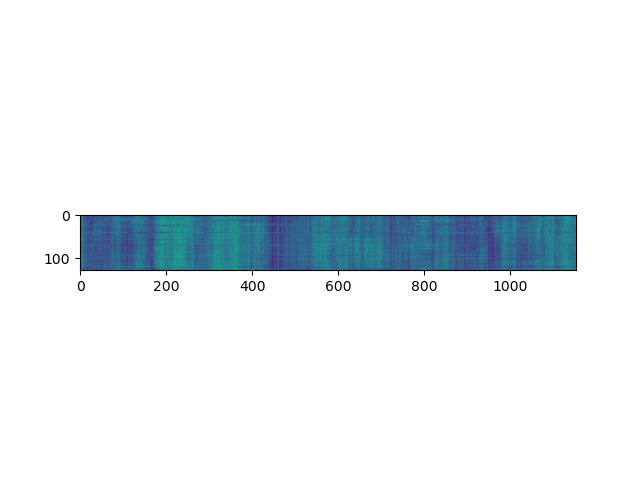

In [7]:
def augment_pipe(data, events):
    rr = np.random.rand()*3
    print(rr)
    aug_data = data + np.random.normal(0, rr, data.shape)
    for i in range(aug_data.shape[0]):
        if np.random.rand() < np.random.rand(): aug_data[i] = np.fliplr(aug_data[i])
        if np.random.rand() < np.random.rand(): aug_data[i] = np.flipud(aug_data[i])
        # salt pepper
        p = np.random.rand() * 0.4
        r = np.random.rand(*aug_data[i].shape)
        u, l = r > (1 - p/2), r < p/2
        aug_data[i][u] = 1#np.max(aug_data[i])
        aug_data[i][l] = -1#np.min(aug_data[i])
    
    return aug_data, events


data_og, events_og = dp.load_data(subjects=[8])
data_og = scipy.stats.zscore(data_og, axis=2)

%matplotlib widget
plt.imshow(data_og[0])


0.6951153810091031


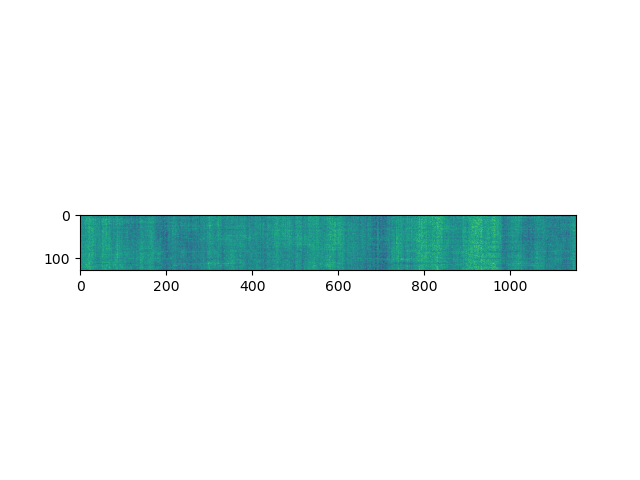

In [8]:
data, events = augment_pipe(data_og, events_og)

%matplotlib widget
plt.imshow(data[0])


In [9]:
data_og[0].shape

(128, 1153)

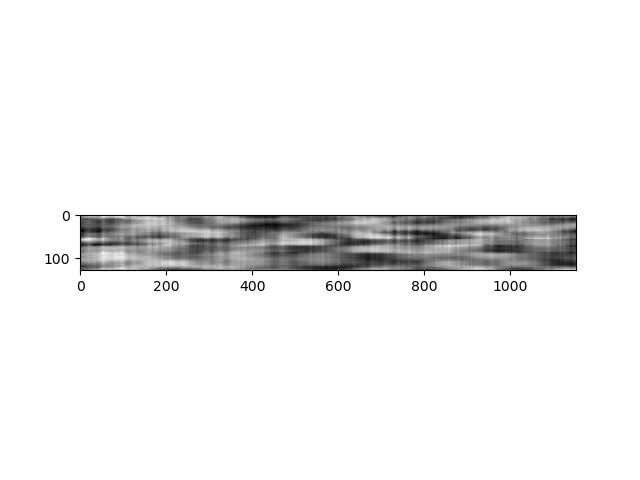

In [13]:
import matplotlib.animation as animation
from perlin_numpy import generate_perlin_noise_3d
import matplotlib.pyplot as plt
import numpy as np
noise = generate_perlin_noise_3d(
    (100, 128, 1200), (5, 8, 8), tileable=(True, False, False)
)
noise = np.random.default_rng().permutation(noise)
noise = data_og[:100, :128, :1153] + 20 * noise[:100, :128, :1153]
noise = scipy.stats.zscore(noise, axis=2)
fig = plt.figure()
images = [
    [plt.imshow(
        layer, cmap='gray', interpolation='lanczos', animated=True
    )]
    for layer in noise
]
animation_3d = animation.ArtistAnimation(fig, images, interval=50, blit=True)
plt.show()


0.5328034276853141

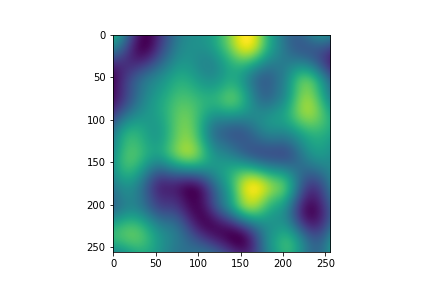

In [159]:
%matplotlib widget
plt.imshow(noise[19])

In [78]:

#data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
#events_og = events_og[:, 1]
#test_losses = [0.3, 0.36, 0.2, 0.3, 0.24, 0.18, 0.18, 0.3, 0.26, 0.22, 0.26, 0.22, 0.34, 0.24, 0.16, 0.26, 0.3, 0.24, 0.36, 0.4, 0.22, 0.3, 0.28, 0.18, 0.26, 0.18, 0.46, 0.3, 0.3, 0.28, 0.28, 0.36, 0.36, 0.16, 0.26, 0.22, 0.22, 0.2, 0.36, 0.2]
for i in range(10):
    tf.keras.backend.clear_session()
    data = np.copy(data_og)
    events = np.copy(events_og)
    data, events = sklearn.utils.shuffle(data, events)
    X_train      = data[0:145,]
    Y_train      = events[0:145]
    X_validate   = data[145:150,]
    Y_validate   = events[145:150]
    X_test       = data[150:,]
    Y_test       = events[150:]
    Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
    Y_validate   = np_utils.to_categorical(Y_validate, num_classes=4)
    Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
    kernels, chans, samples = 1, 128, data.shape[2]
    print(Y_train.shape, Y_test.shape, Y_validate.shape)
    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
    model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])
    class_weights = {0:1, 1:1, 2:1, 3:1}

    ################################################################################
    # fit the model. Due to very small sample sizes this can get
    # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
    # Riemannian geometry classification (below)
    ################################################################################
    fittedModel = model.fit(X_train, Y_train, batch_size = 40, epochs = 150, 
                            verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)
    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("Classification accuracy: %f " % (acc))
    test_losses.append(acc)
    print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))

IndexError: index 199299 is out of bounds for axis 1 with size 4

In [ ]:
print(test_losses)

[0.3, 0.36, 0.2, 0.3, 0.24, 0.18, 0.18, 0.3, 0.26, 0.22, 0.26, 0.22, 0.34, 0.24, 0.16, 0.26, 0.3, 0.24, 0.36, 0.4, 0.22, 0.3, 0.28, 0.18, 0.26, 0.18, 0.46, 0.3, 0.3, 0.28, 0.28, 0.36, 0.36, 0.16, 0.26, 0.22, 0.22, 0.2, 0.36, 0.2]


In [ ]:
data_og, events_og = dp.load_data(subjects=[7])#range(1,11))
data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
events_og = events_og[:, 1]
#test_losses = [0.23333333333333334, 0.28888888888888886, 0.3, 0.24444444444444444, 0.24444444444444444, 0.3111111111111111, 0.3, 0.3111111111111111, 0.26666666666666666, 0.2222222222222222, 0.2222222222222222, 0.24444444444444444, 0.24444444444444444, 0.24444444444444444, 0.17777777777777778, 0.32222222222222224, 0.24444444444444444, 0.2777777777777778, 0.2, 0.25555555555555554, 0.25555555555555554, 0.25555555555555554, 0.26666666666666666, 0.23333333333333334, 0.24444444444444444, 0.2777777777777778, 0.25555555555555554, 0.2222222222222222, 0.37777777777777777, 0.24444444444444444]

for i in range(20):
    tf.keras.backend.clear_session()
    data = np.copy(data_og)
    events = np.copy(events_og)
    data, events = sklearn.utils.shuffle(data, events)
    X_train      = data[0:145,]
    Y_train      = events[0:145]
    X_validate   = data[145:150,]
    Y_validate   = events[145:150]
    X_test       = data[150:,]
    Y_test       = events[150:]
    Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
    Y_validate   = np_utils.to_categorical(Y_validate, num_classes=4)
    Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
    kernels, chans, samples = 1, 128, data.shape[2]
    print(Y_train.shape, Y_test.shape, Y_validate.shape)
    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
    model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')
    # compile the model and set the optimizers
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])
    class_weights = {0:1, 1:1, 2:1, 3:1}

    ################################################################################
    # fit the model. Due to very small sample sizes this can get
    # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
    # Riemannian geometry classification (below)
    ################################################################################
    fittedModel = model.fit(X_train, Y_train, batch_size = 40, epochs = 150, 
                            verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)
    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("Classification accuracy: %f " % (acc))
    test_losses.append(acc)
    print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))
print(test_losses)

(600, 128, 1153)0;0m####################################################################################################]700%
(145, 4) (90, 4) (5, 4)
Epoch 1/150


2022-03-20 13:17:08.372386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 - 2s - loss: 1.3898 - accuracy: 0.2276 - val_loss: 1.3863 - val_accuracy: 0.2000 - 2s/epoch - 456ms/step
Epoch 2/150


2022-03-20 13:17:09.837226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 - 1s - loss: 1.3862 - accuracy: 0.2483 - val_loss: 1.3865 - val_accuracy: 0.2000 - 936ms/epoch - 234ms/step
Epoch 3/150
4/4 - 1s - loss: 1.3842 - accuracy: 0.2621 - val_loss: 1.3865 - val_accuracy: 0.2000 - 904ms/epoch - 226ms/step
Epoch 4/150
4/4 - 1s - loss: 1.3856 - accuracy: 0.2552 - val_loss: 1.3867 - val_accuracy: 0.2000 - 897ms/epoch - 224ms/step
Epoch 5/150
4/4 - 1s - loss: 1.3869 - accuracy: 0.2414 - val_loss: 1.3869 - val_accuracy: 0.2000 - 884ms/epoch - 221ms/step
Epoch 6/150
4/4 - 1s - loss: 1.3842 - accuracy: 0.2414 - val_loss: 1.3873 - val_accuracy: 0.2000 - 883ms/epoch - 221ms/step
Epoch 7/150
4/4 - 1s - loss: 1.3805 - accuracy: 0.3172 - val_loss: 1.3873 - val_accuracy: 0.2000 - 925ms/epoch - 231ms/step
Epoch 8/150
4/4 - 1s - loss: 1.3805 - accuracy: 0.3241 - val_loss: 1.3874 - val_accuracy: 0.2000 - 1s/epoch - 255ms/step
Epoch 9/150
4/4 - 1s - loss: 1.3811 - accuracy: 0.2897 - val_loss: 1.3876 - val_accuracy: 0.2000 - 942ms/epoch - 235ms/step
Epoch 10/150


KeyboardInterrupt: 

In [ ]:
np.concatenate((np.array([1,2,3]), np.array([3,4,5])))
#np.concatenate()

array([1, 2, 3, 3, 4, 5])

25 15 0.273


(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.,
        0., 0., 8., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 7.,
        0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0.,
        0., 0., 5., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.16 , 0.163, 0.166, 0.169, 0.172, 0.175, 0.178, 0.181, 0.184,
        0.187, 0.19 , 0.193, 0.196, 0.199, 0.202, 0.205, 0.208, 0.211,
        0.214, 0.217, 0.22 , 0.223, 0.226, 0.229, 0.232, 0.235, 0.238,
        0.241, 0.244, 0.247, 0.25 , 0.253, 0.256, 0.259, 0.262, 0.265,
        0.268, 0.271, 0.274, 0.277, 0.28 , 0.283, 0.286, 0.289, 0.292,
        0.295, 0.298, 0.301, 0.304, 0.307, 0.31 , 0.313, 0.316, 0.319,
        0.322, 0.325, 0.328, 0.331, 0.334, 0.337, 0.34 , 0.343, 0.346,
        0.349, 0.352, 0.355, 0.358, 0.361, 0.364, 0.3

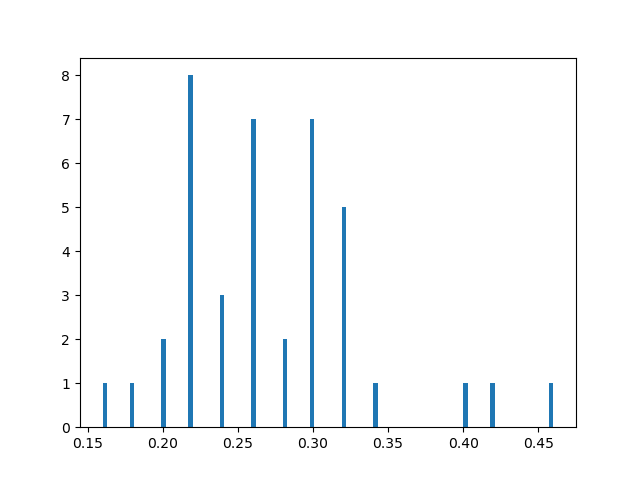

In [19]:
ACC = [0.4, 0.18, 0.26, 0.26, 0.3, 0.26, 0.26, 0.32, 0.22, 0.26, 0.22, 0.34, 0.3, 0.28, 0.22, 0.3, 0.22, 0.24, 0.32, 0.3, 0.26, 0.24, 0.22, 0.24, 0.42, 0.26, 0.3, 0.22, 0.16, 0.3, 0.2, 0.2, 0.3, 0.46, 0.28, 0.32, 0.32, 0.22, 0.22, 0.32]#[0.34, 0.3, 0.24, 0.26, 0.2, 0.38, 0.32, 0.24, 0.26, 0.24, 0.26, 0.28, 0.3, 0.28, 0.24, 0.34, 0.12, 0.36, 0.42, 0.24, 0.28, 0.28, 0.18, 0.26, 0.3, 0.26, 0.14, 0.24, 0.32, 0.28, 0.26, 0.32, 0.2, 0.24, 0.2, 0.26, 0.24, 0.28, 0.14, 0.32]
#ACC = [0.34, 0.3, 0.24, 0.26, 0.2, 0.38, 0.32, 0.24, 0.26, 0.24, 0.26, 0.28, 0.3, 0.28, 0.24, 0.34, 0.12, 0.36, 0.42, 0.24, 0.28, 0.28, 0.18, 0.26, 0.3, 0.26, 0.14, 0.24, 0.32, 0.28, 0.26, 0.32, 0.2, 0.24, 0.2, 0.26, 0.24, 0.28, 0.14, 0.32]

b = [a > 0.25 for a in ACC]
print(b.count(True), b.count(False), np.mean(ACC))
%matplotlib widget

import matplotlib.pyplot as plt
plt.hist(ACC, bins=100)

### Augmented Data Model
- batch size: 12
- dropout: 0.6
- epochs = 40
- kernLength = 64

acccuracy after 10 * [4 * [40 Epochs]] => 0.2655 

25 15 0.2655


(array([1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 1., 0., 0., 3., 0., 0., 0.,
        0., 0., 0., 8., 0., 0., 7., 0., 0., 6., 0., 0., 0., 3., 0., 0., 4.,
        0., 0., 2., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.12 , 0.126, 0.132, 0.138, 0.144, 0.15 , 0.156, 0.162, 0.168,
        0.174, 0.18 , 0.186, 0.192, 0.198, 0.204, 0.21 , 0.216, 0.222,
        0.228, 0.234, 0.24 , 0.246, 0.252, 0.258, 0.264, 0.27 , 0.276,
        0.282, 0.288, 0.294, 0.3  , 0.306, 0.312, 0.318, 0.324, 0.33 ,
        0.336, 0.342, 0.348, 0.354, 0.36 , 0.366, 0.372, 0.378, 0.384,
        0.39 , 0.396, 0.402, 0.408, 0.414, 0.42 ]),
 <BarContainer object of 50 artists>)

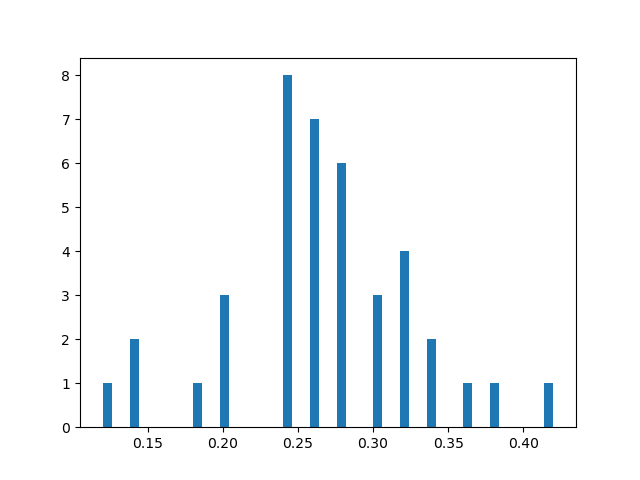

In [25]:
ACC = [0.34, 0.3, 0.24, 0.26, 0.2, 0.38, 0.32, 0.24, 0.26, 0.24, 0.26, 0.28, 0.3, 0.28, 0.24, 0.34, 0.12, 0.36, 0.42, 0.24, 0.28, 0.28, 0.18, 0.26, 0.3, 0.26, 0.14, 0.24, 0.32, 0.28, 0.26, 0.32, 0.2, 0.24, 0.2, 0.26, 0.24, 0.28, 0.14, 0.32]
b = [a > 0.25 for a in ACC]
print(b.count(True), b.count(False), np.mean(ACC))
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(ACC, bins=50)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils
import sklearn
import scipy.stats

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder
from models.classifiers import EEGNet




def augment_pipe(data, events):
    aug_data = data + np.random.normal(0, np.random.rand()/100_000, data.shape)
    for i in range(aug_data.shape[0]):
        if np.random.rand() < np.random.rand(): aug_data[i] = np.fliplr(aug_data[i])
        if np.random.rand() < np.random.rand(): aug_data[i] = np.flipud(aug_data[i])
        # salt pepper
        p = np.random.rand() * 0.4
        r = np.random.rand(*aug_data[i].shape)
        u, l = r > (1 - p/2), r < p/2
        aug_data[i][u] = 1#np.max(aug_data[i])
        aug_data[i][l] = -1#np.min(aug_data[i])
    
    return aug_data, events

ACC = [0.34, 0.3, 0.24, 0.26, 0.2, 0.38, 0.32, 0.24, 0.26, 0.24, 0.26, 0.28, 0.3, 0.28, 0.24, 0.34, 0.12, 0.36, 0.42, 0.24, 0.28, 0.28, 0.18, 0.26, 0.3, 0.26, 0.14, 0.24, 0.32, 0.28, 0.26, 0.32, 0.2, 0.24, 0.2, 0.26, 0.24, 0.28, 0.14, 0.32]

data_og, events_og = dp.load_data(subjects=[8])#range(1,11))
# channels=['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24']
data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
events_og = events_og[:,1]
#cue_interval = dp.filter_interval(data_og, [0.5, 1], 256)
#action_interval = dp.filter_interval(data_og, [1, 3.5], 256)
#events_og = np.concatenate([events_og[:, 1], events_og[:, 1]])
#data_og = np.hstack((cue_interval, action_interval))
test_losses = []
print(data_og.shape, events_og.shape)
data_og = scipy.stats.zscore(data_og,axis=1)
print(data_og.min())

for _ in range(10):
    data, events = sklearn.utils.shuffle(np.copy(data_og), np.copy(events_og))
    X = []
    Y = []
    for i in range(4):
        n, _, _ = data.shape
        X.append(data[int(n/4 * i):int(n/4 * i + n/4)])
        Y.append(events[int(n/4 * i):int(n/4 * i + n/4)])
    
    for i in range(4):
        # concat
        X_train = np.concatenate([d for j, d in enumerate(X) if j != i])
        Y_train = np.concatenate([d for j, d in enumerate(Y) if j != i])
        print(Y_train.shape)
        # augment
        #X_train, Y_train = augment_pipe(X_train, Y_train)
        # shuffle
        X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
        tf.keras.backend.clear_session()
        X_test       = X[i]
        Y_test       = Y[i]
        print(Y_train.shape)
        Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
        Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
        kernels, chans, samples = 1, data.shape[1], data.shape[2]
        # reshape
        X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
        X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        # model intilaization
        model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
                dropoutRate = 0.6, kernLength = 64, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['accuracy'])
        class_weights = {0:1, 1:1, 2:1, 3:1}
        ################################################################################
        # fit the model. Due to very small sample sizes this can get
        # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
        # Riemannian geometry classification (below)
        ################################################################################
        for _ in range(40):
            X_aug, Y_aug = augment_pipe(X_train, Y_train)
            """plt.ioff()
            plt.imshow(X_aug[0])
            plt.show()
            input()"""
            model.fit(X_aug, Y_aug, batch_size = 12, epochs = 1, 
                      verbose = 1, validation_data=(X_test, Y_test), class_weight = class_weights)
        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        print("Classification accuracy: %f " % (acc))
        test_losses.append(acc)
        print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))
print(test_losses)

### Augmented Data Model
- batch size: 40
- dropout: 0.8
- epochs = 150
- kernLength = 128

acccuracy after 10 * [4 * [150 Epochs]] => 0.273

25 15 0.273


(array([1., 0., 0., 1., 0., 0., 2., 0., 0., 8., 0., 0., 0., 3., 0., 0., 7.,
        0., 0., 0., 2., 0., 0., 7., 0., 0., 5., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.16 , 0.166, 0.172, 0.178, 0.184, 0.19 , 0.196, 0.202, 0.208,
        0.214, 0.22 , 0.226, 0.232, 0.238, 0.244, 0.25 , 0.256, 0.262,
        0.268, 0.274, 0.28 , 0.286, 0.292, 0.298, 0.304, 0.31 , 0.316,
        0.322, 0.328, 0.334, 0.34 , 0.346, 0.352, 0.358, 0.364, 0.37 ,
        0.376, 0.382, 0.388, 0.394, 0.4  , 0.406, 0.412, 0.418, 0.424,
        0.43 , 0.436, 0.442, 0.448, 0.454, 0.46 ]),
 <BarContainer object of 50 artists>)

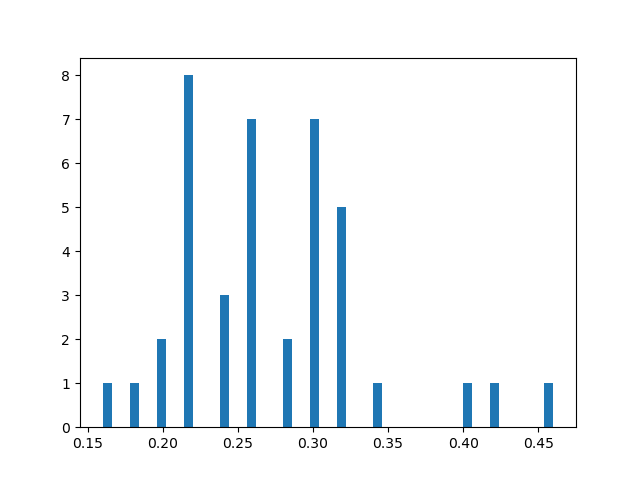

In [27]:
ACC = [0.4, 0.18, 0.26, 0.26, 0.3, 0.26, 0.26, 0.32, 0.22, 0.26, 0.22, 0.34, 0.3, 0.28, 0.22, 0.3, 0.22, 0.24, 0.32, 0.3, 0.26, 0.24, 0.22, 0.24, 0.42, 0.26, 0.3, 0.22, 0.16, 0.3, 0.2, 0.2, 0.3, 0.46, 0.28, 0.32, 0.32, 0.22, 0.22, 0.32]
b = [a > 0.25 for a in ACC]
print(b.count(True), b.count(False), np.mean(ACC))
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(ACC, bins=50)

In [ ]:
data_og, events_og = dp.load_data(subjects=[8])#range(1,11))
# channels=['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24']
# [0.4, 0.18, 0.26, 0.26, 0.3, 0.26, 0.26, 0.32, 0.22, 0.26, 0.22, 0.34, 0.3, 0.28, 0.22, 0.3, 0.22, 0.24, 0.32, 0.3, 0.26, 0.24, 0.22, 0.24, 0.42, 0.26, 0.3, 0.22, 0.16, 0.3, 0.2, 0.2, 0.3, 0.46, 0.28, 0.32, 0.32, 0.22, 0.22, 0.32]
data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
events_og = events_og[:, 1]
test_losses = []


for _ in range(10):
    data, events = sklearn.utils.shuffle(np.copy(data_og), np.copy(events_og))
    X = []
    Y = []

    for i in range(4):
        n, _, _ = data.shape
        X.append(data[int(n/4 * i):int(n/4 * i + n/4)])
        Y.append(events[int(n/4 * i):int(n/4 * i + n/4)])
    for i in range(4):
        X_train = np.concatenate([d for j, d in enumerate(X) if j != i])
        Y_train = np.concatenate([d for j, d in enumerate(Y) if j != i])
        tf.keras.backend.clear_session()
        X_test       = X[i]
        Y_test       = Y[i]
        Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
        Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
        kernels, chans, samples = 1, data.shape[1], data.shape[2]
        X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
        X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
                dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['accuracy'])
        class_weights = {0:1, 1:1, 2:1, 3:1}

        ################################################################################
        # fit the model. Due to very small sample sizes this can get
        # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
        # Riemannian geometry classification (below)
        ################################################################################
        fittedModel = model.fit(X_train, Y_train, batch_size = 40, epochs = 150, 
                                verbose = 1, class_weight = class_weights)
        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        print("Classification accuracy: %f " % (acc))
        test_losses.append(acc)
        print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))
print(test_losses)

### Augmendet Data Model
- batch size: 40
- dropout: 0.6
- epochs = 40
- kernLength = 64

acccuracy after 10 * [4 * [40 Epochs]] => 0.261

26 14 0.261


(array([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 4., 0., 0., 2., 0., 0., 4.,
        0., 0., 0., 2., 0., 0., 6., 0., 0., 8., 0., 0., 0., 6., 0., 0., 3.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.12 , 0.126, 0.132, 0.138, 0.144, 0.15 , 0.156, 0.162, 0.168,
        0.174, 0.18 , 0.186, 0.192, 0.198, 0.204, 0.21 , 0.216, 0.222,
        0.228, 0.234, 0.24 , 0.246, 0.252, 0.258, 0.264, 0.27 , 0.276,
        0.282, 0.288, 0.294, 0.3  , 0.306, 0.312, 0.318, 0.324, 0.33 ,
        0.336, 0.342, 0.348, 0.354, 0.36 , 0.366, 0.372, 0.378, 0.384,
        0.39 , 0.396, 0.402, 0.408, 0.414, 0.42 ]),
 <BarContainer object of 50 artists>)

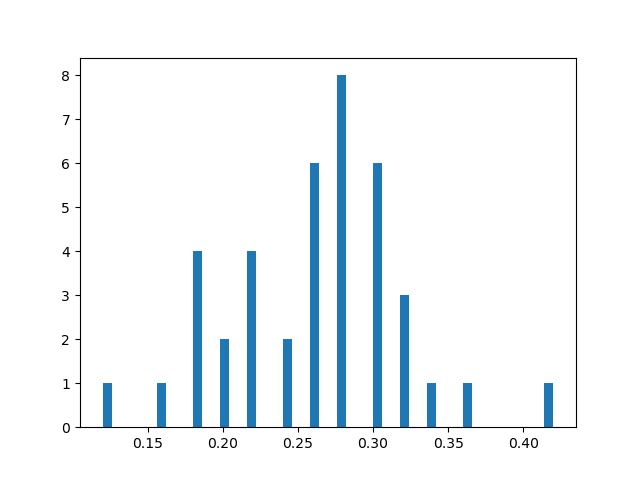

In [29]:
ACC = [0.32, 0.34, 0.28, 0.3, 0.26, 0.26, 0.22, 0.28, 0.28, 0.28, 0.24, 0.26, 0.3, 0.3, 0.36, 0.2, 0.3, 0.2, 0.18, 0.3, 0.32, 0.28, 0.26, 0.22, 0.42, 0.16, 0.32, 0.12, 0.28, 0.18, 0.24, 0.28, 0.22, 0.18, 0.26, 0.22, 0.3, 0.28, 0.18, 0.26]
b = [a > 0.25 for a in ACC]
print(b.count(True), b.count(False), np.mean(ACC))
%matplotlib widget
import matplotlib.pyplot as plt
plt.hist(ACC, bins=50)

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils
import sklearn
import scipy.stats

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder
from models.classifiers import EEGNet

def augment_pipe(data, events):
    aug_data = data + np.random.normal(0, np.random.rand()/100_000, data.shape)
    for i in range(aug_data.shape[0]):
        if np.random.rand() < np.random.rand(): aug_data[i] = np.fliplr(aug_data[i])
        if np.random.rand() < np.random.rand(): aug_data[i] = np.flipud(aug_data[i])
        # salt pepper
        p = np.random.rand() * 0.4
        r = np.random.rand(*aug_data[i].shape)
        u, l = r > (1 - p/2), r < p/2
        aug_data[i][u] = 1#np.max(aug_data[i])
        aug_data[i][l] = -1#np.min(aug_data[i])
    
    return aug_data, events

data_og, events_og = dp.load_data(subjects=[8])#range(1,11))
# channels=['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24']
# [0.32, 0.34, 0.28, 0.3, 0.26, 0.26, 0.22, 0.28, 0.28, 0.28, 0.24, 0.26, 0.3, 0.3, 0.36, 0.2, 0.3, 0.2, 0.18, 0.3, 0.32, 0.28, 0.26, 0.22, 0.42, 0.16, 0.32, 0.12, 0.28, 0.18, 0.24, 0.28, 0.22, 0.18, 0.26, 0.22, 0.3, 0.28, 0.18, 0.26]
data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
events_og = events_og[:,1]
#cue_interval = dp.filter_interval(data_og, [0.5, 1], 256)
#action_interval = dp.filter_interval(data_og, [1, 3.5], 256)
#events_og = np.concatenate([events_og[:, 1], events_og[:, 1]])
#data_og = np.hstack((cue_interval, action_interval))
test_losses = []
print(data_og.shape, events_og.shape)
data_og = scipy.stats.zscore(data_og,axis=1)
print(data_og.min())


for _ in range(10):
    data, events = sklearn.utils.shuffle(np.copy(data_og), np.copy(events_og))
    X = []
    Y = []
    for i in range(4):
        n, _, _ = data.shape
        X.append(data[int(n/4 * i):int(n/4 * i + n/4)])
        Y.append(events[int(n/4 * i):int(n/4 * i + n/4)])
    
    for i in range(4):
        # concat
        X_train = np.concatenate([d for j, d in enumerate(X) if j != i])
        Y_train = np.concatenate([d for j, d in enumerate(Y) if j != i])
        print(Y_train.shape)
        # augment
        #X_train, Y_train = augment_pipe(X_train, Y_train)
        # shuffle
        X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
        tf.keras.backend.clear_session()
        X_test       = X[i]
        Y_test       = Y[i]
        print(Y_train.shape)
        Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
        Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
        kernels, chans, samples = 1, data.shape[1], data.shape[2]
        # reshape
        X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
        X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        # model intilaization
        model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
                dropoutRate = 0.6, kernLength = 64, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['accuracy'])
        class_weights = {0:1, 1:1, 2:1, 3:1}
        ################################################################################
        # fit the model. Due to very small sample sizes this can get
        # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
        # Riemannian geometry classification (below)
        ################################################################################
        for _ in range(40):
            X_aug, Y_aug = augment_pipe(X_train, Y_train)
            """plt.ioff()
            plt.imshow(X_aug[0])
            plt.show()
            input()"""
            model.fit(X_aug, Y_aug, batch_size = 40, epochs = 1, 
                      verbose = 1, validation_data=(X_test, Y_test), class_weight = class_weights)
        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        print("Classification accuracy: %f " % (acc))
        test_losses.append(acc)
        print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))
print(test_losses)

In [30]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import utils as np_utils
import sklearn
import scipy.stats

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder
from models.classifiers import EEGNet

def augment_pipe(data, events):
    aug_data = data + np.random.normal(0, np.random.rand()/100_000, data.shape)
    for i in range(aug_data.shape[0]):
        if np.random.rand() < np.random.rand(): aug_data[i] = np.fliplr(aug_data[i])
        if np.random.rand() < np.random.rand(): aug_data[i] = np.flipud(aug_data[i])
        # salt pepper
        p = np.random.rand() * 0.4
        r = np.random.rand(*aug_data[i].shape)
        u, l = r > (1 - p/2), r < p/2
        aug_data[i][u] = 1#np.max(aug_data[i])
        aug_data[i][l] = -1#np.min(aug_data[i])
    
    return aug_data, events

data_og, events_og = dp.load_data(subjects=[8])#range(1,11))
# channels=['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24']
data_og, events_og = dp.choose_condition(data_og, events_og, 'inner speech')
events_og = events_og[:,1]
#cue_interval = dp.filter_interval(data_og, [0.5, 1], 256)
#action_interval = dp.filter_interval(data_og, [1, 3.5], 256)
#events_og = np.concatenate([events_og[:, 1], events_og[:, 1]])
#data_og = np.hstack((cue_interval, action_interval))
test_losses = []
print(data_og.shape, events_og.shape)
data_og = scipy.stats.zscore(data_og,axis=1)
print(data_og.min())


for _ in range(10):
    data, events = sklearn.utils.shuffle(np.copy(data_og), np.copy(events_og))
    X = []
    Y = []
    for i in range(4):
        n, _, _ = data.shape
        X.append(data[int(n/4 * i):int(n/4 * i + n/4)])
        Y.append(events[int(n/4 * i):int(n/4 * i + n/4)])
    
    for i in range(4):
        # concat
        X_train = np.concatenate([d for j, d in enumerate(X) if j != i])
        Y_train = np.concatenate([d for j, d in enumerate(Y) if j != i])
        print(Y_train.shape)
        # augment
        #X_train, Y_train = augment_pipe(X_train, Y_train)
        # shuffle
        X_train, Y_train = sklearn.utils.shuffle(X_train, Y_train)
        tf.keras.backend.clear_session()
        X_test       = X[i]
        Y_test       = Y[i]
        print(Y_train.shape)
        Y_train      = np_utils.to_categorical(Y_train, num_classes=4)
        Y_test       = np_utils.to_categorical(Y_test, num_classes=4)
        kernels, chans, samples = 1, data.shape[1], data.shape[2]
        # reshape
        X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
        X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        # model intilaization
        model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
                dropoutRate = 0.6, kernLength = 64, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')
        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics = ['accuracy'])
        class_weights = {0:1, 1:1, 2:1, 3:1}
        ################################################################################
        # fit the model. Due to very small sample sizes this can get
        # pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
        # Riemannian geometry classification (below)
        ################################################################################
        for _ in range(40):
            X_aug, Y_aug = augment_pipe(X_train, Y_train)
            """plt.ioff()
            plt.imshow(X_aug[0])
            plt.show()
            input()"""
            model.fit(X_aug, Y_aug, batch_size = 40, epochs = 3, 
                      verbose = 1, validation_data=(X_test, Y_test), class_weight = class_weights)
        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)  
        acc         = np.mean(preds == Y_test.argmax(axis=-1))
        print("Classification accuracy: %f " % (acc))
        test_losses.append(acc)
        print(len(test_losses), "TEST LOSSSSSS:", np.mean(test_losses))
print("##################################################")
print("Average test loss:", np.mean(test_losses))
print(test_losses)

(200, 128, 1153) (200,)38;2;252;2;0m###################################################################################################]800%
-11.264297979061753
(150,)
(150,)
Epoch 1/3


2022-03-21 18:33:18.706878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4777 - accuracy: 0.2600

2022-03-21 18:33:20.804022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 467ms/step - loss: 1.4777 - accuracy: 0.2600 - val_loss: 1.3836 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 220ms/step - loss: 1.3779 - accuracy: 0.3133 - val_loss: 1.3825 - val_accuracy: 0.3600
Epoch 3/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3484 - accuracy: 0.3667 - val_loss: 1.3815 - val_accuracy: 0.3600
Epoch 1/3
4/4 [==============================] - 1s 247ms/step - loss: 1.3689 - accuracy: 0.3067 - val_loss: 1.3807 - val_accuracy: 0.3800
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3537 - accuracy: 0.3133 - val_loss: 1.3798 - val_accuracy: 0.3800
Epoch 3/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3402 - accuracy: 0.3733 - val_loss: 1.3789 - val_accuracy: 0.3800
Epoch 1/3
4/4 [==============================] - 1s 234ms/step - loss: 1.3537 - accuracy: 0.3333 - val_loss: 1.3780 - val_accuracy: 0.3400
Epoch 2/3
4/4 [======================

2022-03-21 18:35:30.982186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.280000 
1 TEST LOSSSSSS: 0.28
(150,)
(150,)
Epoch 1/3


2022-03-21 18:35:33.670696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5289 - accuracy: 0.2533

2022-03-21 18:35:35.033941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 354ms/step - loss: 1.5289 - accuracy: 0.2533 - val_loss: 1.3826 - val_accuracy: 0.3000
Epoch 2/3
4/4 [==============================] - 1s 210ms/step - loss: 1.3569 - accuracy: 0.3267 - val_loss: 1.3819 - val_accuracy: 0.3000
Epoch 3/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3257 - accuracy: 0.4200 - val_loss: 1.3813 - val_accuracy: 0.3200
Epoch 1/3
4/4 [==============================] - 1s 213ms/step - loss: 1.3846 - accuracy: 0.2733 - val_loss: 1.3809 - val_accuracy: 0.3000
Epoch 2/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3757 - accuracy: 0.3133 - val_loss: 1.3804 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3419 - accuracy: 0.4067 - val_loss: 1.3802 - val_accuracy: 0.3400
Epoch 1/3
4/4 [==============================] - 1s 210ms/step - loss: 1.3533 - accuracy: 0.3000 - val_loss: 1.3801 - val_accuracy: 0.3200
Epoch 2/3
4/4 [======================

2022-03-21 18:37:36.016016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.240000 
2 TEST LOSSSSSS: 0.26
(150,)
(150,)
Epoch 1/3


2022-03-21 18:37:37.351333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4683 - accuracy: 0.2267

2022-03-21 18:37:38.665651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 342ms/step - loss: 1.4683 - accuracy: 0.2267 - val_loss: 1.3875 - val_accuracy: 0.1600
Epoch 2/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3683 - accuracy: 0.2733 - val_loss: 1.3874 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3149 - accuracy: 0.4000 - val_loss: 1.3873 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 223ms/step - loss: 1.3497 - accuracy: 0.3200 - val_loss: 1.3873 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 195ms/step - loss: 1.3690 - accuracy: 0.2600 - val_loss: 1.3872 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3406 - accuracy: 0.3200 - val_loss: 1.3879 - val_accuracy: 0.2200
Epoch 1/3
4/4 [==============================] - 1s 209ms/step - loss: 1.3616 - accuracy: 0.3200 - val_loss: 1.3894 - val_accuracy: 0.1800
Epoch 2/3
4/4 [======================

2022-03-21 18:39:41.222906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.200000 
3 TEST LOSSSSSS: 0.24
(150,)
(150,)
Epoch 1/3


2022-03-21 18:39:42.425579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4590 - accuracy: 0.2133

2022-03-21 18:39:43.650685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 308ms/step - loss: 1.4590 - accuracy: 0.2133 - val_loss: 1.3865 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3681 - accuracy: 0.2933 - val_loss: 1.3863 - val_accuracy: 0.3400
Epoch 3/3
4/4 [==============================] - 1s 195ms/step - loss: 1.3295 - accuracy: 0.4133 - val_loss: 1.3861 - val_accuracy: 0.3400
Epoch 1/3
4/4 [==============================] - 1s 220ms/step - loss: 1.3856 - accuracy: 0.2533 - val_loss: 1.3859 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 196ms/step - loss: 1.3507 - accuracy: 0.3400 - val_loss: 1.3851 - val_accuracy: 0.3000
Epoch 3/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3529 - accuracy: 0.3733 - val_loss: 1.3840 - val_accuracy: 0.2800
Epoch 1/3
4/4 [==============================] - 1s 207ms/step - loss: 1.3637 - accuracy: 0.3400 - val_loss: 1.3826 - val_accuracy: 0.3400
Epoch 2/3
4/4 [======================

2022-03-21 18:41:44.486834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.320000 
4 TEST LOSSSSSS: 0.26
(150,)
(150,)
Epoch 1/3


2022-03-21 18:41:46.267507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4999 - accuracy: 0.2333

2022-03-21 18:41:47.606799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 333ms/step - loss: 1.4999 - accuracy: 0.2333 - val_loss: 1.3872 - val_accuracy: 0.1400
Epoch 2/3
4/4 [==============================] - 1s 210ms/step - loss: 1.4015 - accuracy: 0.2533 - val_loss: 1.3872 - val_accuracy: 0.1400
Epoch 3/3
4/4 [==============================] - 1s 198ms/step - loss: 1.3571 - accuracy: 0.3133 - val_loss: 1.3874 - val_accuracy: 0.2000
Epoch 1/3
4/4 [==============================] - 1s 222ms/step - loss: 1.3894 - accuracy: 0.2800 - val_loss: 1.3877 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 196ms/step - loss: 1.3732 - accuracy: 0.2267 - val_loss: 1.3883 - val_accuracy: 0.2200
Epoch 3/3
4/4 [==============================] - 1s 198ms/step - loss: 1.3574 - accuracy: 0.3733 - val_loss: 1.3890 - val_accuracy: 0.2000
Epoch 1/3
4/4 [==============================] - 1s 219ms/step - loss: 1.3385 - accuracy: 0.3733 - val_loss: 1.3904 - val_accuracy: 0.2000
Epoch 2/3
4/4 [======================

2022-03-21 18:43:48.478225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.200000 
5 TEST LOSSSSSS: 0.248
(150,)
(150,)
Epoch 1/3


2022-03-21 18:43:49.889017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 302ms/step - loss: 1.5024 - accuracy: 0.2533 - val_loss: 1.3855 - val_accuracy: 0.3200
Epoch 2/3


2022-03-21 18:43:51.098818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 199ms/step - loss: 1.3637 - accuracy: 0.3267 - val_loss: 1.3859 - val_accuracy: 0.3400
Epoch 3/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3640 - accuracy: 0.3200 - val_loss: 1.3861 - val_accuracy: 0.2800
Epoch 1/3
4/4 [==============================] - 1s 218ms/step - loss: 1.3667 - accuracy: 0.3600 - val_loss: 1.3865 - val_accuracy: 0.2600
Epoch 2/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3501 - accuracy: 0.3533 - val_loss: 1.3866 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 196ms/step - loss: 1.3489 - accuracy: 0.3800 - val_loss: 1.3860 - val_accuracy: 0.3000
Epoch 1/3
4/4 [==============================] - 1s 227ms/step - loss: 1.3825 - accuracy: 0.2733 - val_loss: 1.3853 - val_accuracy: 0.3200
Epoch 2/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3577 - accuracy: 0.3267 - val_loss: 1.3846 - val_accuracy: 0.3400
Epoch 3/3
4/4 [======================

2022-03-21 18:45:57.580869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
6 TEST LOSSSSSS: 0.24333333333333332
(150,)
(150,)
Epoch 1/3


2022-03-21 18:46:00.248863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5344 - accuracy: 0.2400

2022-03-21 18:46:01.488914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 341ms/step - loss: 1.5344 - accuracy: 0.2400 - val_loss: 1.3878 - val_accuracy: 0.1800
Epoch 2/3
4/4 [==============================] - 1s 218ms/step - loss: 1.3802 - accuracy: 0.3267 - val_loss: 1.3883 - val_accuracy: 0.2200
Epoch 3/3
4/4 [==============================] - 1s 218ms/step - loss: 1.3396 - accuracy: 0.4067 - val_loss: 1.3889 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 232ms/step - loss: 1.3796 - accuracy: 0.3400 - val_loss: 1.3890 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 214ms/step - loss: 1.3681 - accuracy: 0.3400 - val_loss: 1.3888 - val_accuracy: 0.3000
Epoch 3/3
4/4 [==============================] - 1s 209ms/step - loss: 1.3388 - accuracy: 0.3667 - val_loss: 1.3883 - val_accuracy: 0.3200
Epoch 1/3
4/4 [==============================] - 1s 217ms/step - loss: 1.3678 - accuracy: 0.3333 - val_loss: 1.3878 - val_accuracy: 0.3000
Epoch 2/3
4/4 [======================

2022-03-21 18:48:01.221894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.260000 
7 TEST LOSSSSSS: 0.24571428571428572
(150,)
(150,)
Epoch 1/3


2022-03-21 18:48:02.482336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 330ms/step - loss: 1.4802 - accuracy: 0.2267 - val_loss: 1.3868 - val_accuracy: 0.2000
Epoch 2/3


2022-03-21 18:48:03.768009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 207ms/step - loss: 1.3807 - accuracy: 0.3000 - val_loss: 1.3867 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 206ms/step - loss: 1.3509 - accuracy: 0.3600 - val_loss: 1.3864 - val_accuracy: 0.2200
Epoch 1/3
4/4 [==============================] - 1s 216ms/step - loss: 1.3858 - accuracy: 0.3067 - val_loss: 1.3861 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 273ms/step - loss: 1.3640 - accuracy: 0.3600 - val_loss: 1.3859 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3432 - accuracy: 0.3400 - val_loss: 1.3857 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 226ms/step - loss: 1.3590 - accuracy: 0.3133 - val_loss: 1.3856 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3589 - accuracy: 0.3200 - val_loss: 1.3859 - val_accuracy: 0.2800
Epoch 3/3
4/4 [======================

2022-03-21 18:50:04.491501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.240000 
8 TEST LOSSSSSS: 0.245
(150,)
(150,)
Epoch 1/3


2022-03-21 18:50:06.296092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 313ms/step - loss: 1.4211 - accuracy: 0.3200 - val_loss: 1.3861 - val_accuracy: 0.2400
Epoch 2/3


2022-03-21 18:50:07.634468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 205ms/step - loss: 1.3572 - accuracy: 0.3400 - val_loss: 1.3862 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3211 - accuracy: 0.4200 - val_loss: 1.3868 - val_accuracy: 0.2000
Epoch 1/3
4/4 [==============================] - 1s 216ms/step - loss: 1.3595 - accuracy: 0.3800 - val_loss: 1.3874 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 195ms/step - loss: 1.3591 - accuracy: 0.3733 - val_loss: 1.3885 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 191ms/step - loss: 1.3332 - accuracy: 0.3733 - val_loss: 1.3901 - val_accuracy: 0.2200
Epoch 1/3
4/4 [==============================] - 1s 210ms/step - loss: 1.3427 - accuracy: 0.3267 - val_loss: 1.3917 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 195ms/step - loss: 1.3286 - accuracy: 0.4000 - val_loss: 1.3929 - val_accuracy: 0.2800
Epoch 3/3
4/4 [======================

2022-03-21 18:52:08.739753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.240000 
9 TEST LOSSSSSS: 0.24444444444444446
(150,)
(150,)
Epoch 1/3


2022-03-21 18:52:11.347007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5036 - accuracy: 0.3000

2022-03-21 18:52:12.568107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 328ms/step - loss: 1.5036 - accuracy: 0.3000 - val_loss: 1.3856 - val_accuracy: 0.2600
Epoch 2/3
4/4 [==============================] - 1s 204ms/step - loss: 1.3481 - accuracy: 0.3867 - val_loss: 1.3863 - val_accuracy: 0.2800
Epoch 3/3
4/4 [==============================] - 1s 200ms/step - loss: 1.3323 - accuracy: 0.4067 - val_loss: 1.3871 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3674 - accuracy: 0.3067 - val_loss: 1.3873 - val_accuracy: 0.2600
Epoch 2/3
4/4 [==============================] - 1s 206ms/step - loss: 1.3722 - accuracy: 0.3600 - val_loss: 1.3864 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3227 - accuracy: 0.3933 - val_loss: 1.3850 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3507 - accuracy: 0.3533 - val_loss: 1.3834 - val_accuracy: 0.2800
Epoch 2/3
4/4 [======================

2022-03-21 18:54:11.111220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.280000 
10 TEST LOSSSSSS: 0.24800000000000005
(150,)
(150,)
Epoch 1/3


2022-03-21 18:54:12.585278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4563 - accuracy: 0.2400

2022-03-21 18:54:13.979322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 354ms/step - loss: 1.4563 - accuracy: 0.2400 - val_loss: 1.3845 - val_accuracy: 0.3400
Epoch 2/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3658 - accuracy: 0.2867 - val_loss: 1.3848 - val_accuracy: 0.2800
Epoch 3/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3483 - accuracy: 0.3733 - val_loss: 1.3849 - val_accuracy: 0.2200
Epoch 1/3
4/4 [==============================] - 1s 213ms/step - loss: 1.3837 - accuracy: 0.3333 - val_loss: 1.3848 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 194ms/step - loss: 1.3677 - accuracy: 0.2800 - val_loss: 1.3847 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 198ms/step - loss: 1.3461 - accuracy: 0.3733 - val_loss: 1.3845 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 233ms/step - loss: 1.3570 - accuracy: 0.3133 - val_loss: 1.3839 - val_accuracy: 0.2600
Epoch 2/3
4/4 [======================

2022-03-21 18:56:14.957095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.240000 
11 TEST LOSSSSSS: 0.24727272727272734
(150,)
(150,)
Epoch 1/3


2022-03-21 18:56:16.489111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4652 - accuracy: 0.2200

2022-03-21 18:56:17.775405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 325ms/step - loss: 1.4652 - accuracy: 0.2200 - val_loss: 1.3862 - val_accuracy: 0.2600
Epoch 2/3
4/4 [==============================] - 1s 204ms/step - loss: 1.3810 - accuracy: 0.2867 - val_loss: 1.3861 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3325 - accuracy: 0.3600 - val_loss: 1.3858 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 218ms/step - loss: 1.4066 - accuracy: 0.2067 - val_loss: 1.3855 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 198ms/step - loss: 1.3660 - accuracy: 0.3133 - val_loss: 1.3856 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 193ms/step - loss: 1.3476 - accuracy: 0.3200 - val_loss: 1.3861 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 225ms/step - loss: 1.3652 - accuracy: 0.2800 - val_loss: 1.3874 - val_accuracy: 0.2200
Epoch 2/3
4/4 [======================

2022-03-21 18:58:19.358873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.180000 
12 TEST LOSSSSSS: 0.24166666666666672
(150,)
(150,)
Epoch 1/3


2022-03-21 18:58:22.437436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5383 - accuracy: 0.2133

2022-03-21 18:58:23.613680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 313ms/step - loss: 1.5383 - accuracy: 0.2133 - val_loss: 1.3883 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3652 - accuracy: 0.3400 - val_loss: 1.3878 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 204ms/step - loss: 1.3238 - accuracy: 0.3933 - val_loss: 1.3871 - val_accuracy: 0.2800
Epoch 1/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3927 - accuracy: 0.2467 - val_loss: 1.3870 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3571 - accuracy: 0.3333 - val_loss: 1.3874 - val_accuracy: 0.2800
Epoch 3/3
4/4 [==============================] - 1s 196ms/step - loss: 1.3313 - accuracy: 0.4200 - val_loss: 1.3883 - val_accuracy: 0.3000
Epoch 1/3
4/4 [==============================] - 1s 208ms/step - loss: 1.3640 - accuracy: 0.3400 - val_loss: 1.3884 - val_accuracy: 0.2800
Epoch 2/3
4/4 [======================

2022-03-21 19:00:22.547641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.280000 
13 TEST LOSSSSSS: 0.24461538461538465
(150,)
(150,)
Epoch 1/3


2022-03-21 19:00:23.957694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4765 - accuracy: 0.2333

2022-03-21 19:00:25.291746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 334ms/step - loss: 1.4765 - accuracy: 0.2333 - val_loss: 1.3858 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 203ms/step - loss: 1.3778 - accuracy: 0.2267 - val_loss: 1.3867 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 203ms/step - loss: 1.3582 - accuracy: 0.3467 - val_loss: 1.3872 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 243ms/step - loss: 1.3853 - accuracy: 0.2933 - val_loss: 1.3877 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3525 - accuracy: 0.3400 - val_loss: 1.3880 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 194ms/step - loss: 1.3347 - accuracy: 0.3667 - val_loss: 1.3888 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3598 - accuracy: 0.3600 - val_loss: 1.3898 - val_accuracy: 0.2400
Epoch 2/3
4/4 [======================

2022-03-21 19:09:44.252715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
14 TEST LOSSSSSS: 0.2428571428571429
(150,)
(150,)
Epoch 1/3


2022-03-21 19:09:45.553321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4561 - accuracy: 0.2667

2022-03-21 19:09:46.824028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 312ms/step - loss: 1.4561 - accuracy: 0.2667 - val_loss: 1.3871 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3650 - accuracy: 0.3467 - val_loss: 1.3865 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3301 - accuracy: 0.3800 - val_loss: 1.3865 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 235ms/step - loss: 1.3635 - accuracy: 0.3200 - val_loss: 1.3864 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 198ms/step - loss: 1.3702 - accuracy: 0.3133 - val_loss: 1.3858 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3434 - accuracy: 0.3533 - val_loss: 1.3851 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 207ms/step - loss: 1.3731 - accuracy: 0.3400 - val_loss: 1.3841 - val_accuracy: 0.2200
Epoch 2/3
4/4 [======================

2022-03-21 21:43:51.494232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.300000 
15 TEST LOSSSSSS: 0.2466666666666667
(150,)
(150,)
Epoch 1/3


2022-03-21 21:43:54.982492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4780 - accuracy: 0.2667

2022-03-21 21:43:56.366559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 339ms/step - loss: 1.4780 - accuracy: 0.2667 - val_loss: 1.3871 - val_accuracy: 0.1800
Epoch 2/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3638 - accuracy: 0.3667 - val_loss: 1.3882 - val_accuracy: 0.1400
Epoch 3/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3320 - accuracy: 0.3667 - val_loss: 1.3890 - val_accuracy: 0.1600
Epoch 1/3
4/4 [==============================] - 1s 214ms/step - loss: 1.3628 - accuracy: 0.3400 - val_loss: 1.3896 - val_accuracy: 0.1800
Epoch 2/3
4/4 [==============================] - 1s 228ms/step - loss: 1.3428 - accuracy: 0.3267 - val_loss: 1.3901 - val_accuracy: 0.1600
Epoch 3/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3410 - accuracy: 0.3400 - val_loss: 1.3905 - val_accuracy: 0.1400
Epoch 1/3
4/4 [==============================] - 1s 223ms/step - loss: 1.3613 - accuracy: 0.3133 - val_loss: 1.3908 - val_accuracy: 0.1400
Epoch 2/3
4/4 [======================

2022-03-21 21:46:02.773403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.140000 
16 TEST LOSSSSSS: 0.24
(150,)
(150,)
Epoch 1/3


2022-03-21 21:46:04.837969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.6082 - accuracy: 0.1933

2022-03-21 21:46:06.409819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 422ms/step - loss: 1.6082 - accuracy: 0.1933 - val_loss: 1.3863 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 221ms/step - loss: 1.3626 - accuracy: 0.3000 - val_loss: 1.3865 - val_accuracy: 0.1800
Epoch 3/3
4/4 [==============================] - 1s 219ms/step - loss: 1.3271 - accuracy: 0.4000 - val_loss: 1.3873 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 242ms/step - loss: 1.3811 - accuracy: 0.2600 - val_loss: 1.3880 - val_accuracy: 0.1600
Epoch 2/3
4/4 [==============================] - 1s 208ms/step - loss: 1.3710 - accuracy: 0.3133 - val_loss: 1.3879 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 208ms/step - loss: 1.3459 - accuracy: 0.3067 - val_loss: 1.3878 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 311ms/step - loss: 1.3725 - accuracy: 0.2867 - val_loss: 1.3879 - val_accuracy: 0.2200
Epoch 2/3
4/4 [======================

2022-03-21 21:48:18.191186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.280000 
17 TEST LOSSSSSS: 0.2423529411764706
(150,)
(150,)
Epoch 1/3


2022-03-21 21:48:19.702325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4852 - accuracy: 0.2200

2022-03-21 21:48:21.375903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 476ms/step - loss: 1.4852 - accuracy: 0.2200 - val_loss: 1.3881 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 228ms/step - loss: 1.3482 - accuracy: 0.3867 - val_loss: 1.3887 - val_accuracy: 0.1800
Epoch 3/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3318 - accuracy: 0.3933 - val_loss: 1.3890 - val_accuracy: 0.2000
Epoch 1/3
4/4 [==============================] - 1s 226ms/step - loss: 1.3551 - accuracy: 0.3600 - val_loss: 1.3890 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3616 - accuracy: 0.3067 - val_loss: 1.3894 - val_accuracy: 0.2200
Epoch 3/3
4/4 [==============================] - 1s 224ms/step - loss: 1.3556 - accuracy: 0.3800 - val_loss: 1.3897 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 249ms/step - loss: 1.3593 - accuracy: 0.3200 - val_loss: 1.3898 - val_accuracy: 0.2600
Epoch 2/3
4/4 [======================

2022-03-21 21:50:33.755654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
18 TEST LOSSSSSS: 0.2411111111111111
(150,)
(150,)
Epoch 1/3


2022-03-21 21:50:35.268211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4298 - accuracy: 0.2800

2022-03-21 21:50:37.602287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 539ms/step - loss: 1.4298 - accuracy: 0.2800 - val_loss: 1.3850 - val_accuracy: 0.3600
Epoch 2/3
4/4 [==============================] - 1s 230ms/step - loss: 1.3766 - accuracy: 0.3000 - val_loss: 1.3852 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 239ms/step - loss: 1.3667 - accuracy: 0.2600 - val_loss: 1.3851 - val_accuracy: 0.3200
Epoch 1/3
4/4 [==============================] - 1s 388ms/step - loss: 1.3916 - accuracy: 0.2867 - val_loss: 1.3850 - val_accuracy: 0.3000
Epoch 2/3
4/4 [==============================] - 1s 238ms/step - loss: 1.3926 - accuracy: 0.2800 - val_loss: 1.3852 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 224ms/step - loss: 1.3462 - accuracy: 0.3800 - val_loss: 1.3854 - val_accuracy: 0.3000
Epoch 1/3
4/4 [==============================] - 1s 227ms/step - loss: 1.3804 - accuracy: 0.2600 - val_loss: 1.3857 - val_accuracy: 0.2200
Epoch 2/3
4/4 [======================

2022-03-21 21:52:45.170498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
19 TEST LOSSSSSS: 0.24
(150,)
(150,)
Epoch 1/3


2022-03-21 21:52:46.683558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4423 - accuracy: 0.2467

2022-03-21 21:52:48.181815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 377ms/step - loss: 1.4423 - accuracy: 0.2467 - val_loss: 1.3842 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 214ms/step - loss: 1.3384 - accuracy: 0.3733 - val_loss: 1.3825 - val_accuracy: 0.4000
Epoch 3/3
4/4 [==============================] - 1s 205ms/step - loss: 1.3359 - accuracy: 0.4000 - val_loss: 1.3811 - val_accuracy: 0.3800
Epoch 1/3
4/4 [==============================] - 1s 231ms/step - loss: 1.3732 - accuracy: 0.3200 - val_loss: 1.3797 - val_accuracy: 0.4000
Epoch 2/3
4/4 [==============================] - 1s 203ms/step - loss: 1.3560 - accuracy: 0.3467 - val_loss: 1.3778 - val_accuracy: 0.4000
Epoch 3/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3130 - accuracy: 0.4733 - val_loss: 1.3761 - val_accuracy: 0.4200
Epoch 1/3
4/4 [==============================] - 1s 228ms/step - loss: 1.3597 - accuracy: 0.3733 - val_loss: 1.3756 - val_accuracy: 0.3800
Epoch 2/3
4/4 [======================

2022-03-21 21:54:54.760735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.200000 
20 TEST LOSSSSSS: 0.238
(150,)
(150,)
Epoch 1/3


2022-03-21 21:54:58.058741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5449 - accuracy: 0.1800

2022-03-21 21:54:59.449220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 364ms/step - loss: 1.5449 - accuracy: 0.1800 - val_loss: 1.3863 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 214ms/step - loss: 1.3658 - accuracy: 0.3133 - val_loss: 1.3854 - val_accuracy: 0.2200
Epoch 3/3
4/4 [==============================] - 1s 203ms/step - loss: 1.3247 - accuracy: 0.4333 - val_loss: 1.3847 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 221ms/step - loss: 1.3621 - accuracy: 0.3333 - val_loss: 1.3837 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 197ms/step - loss: 1.3606 - accuracy: 0.3200 - val_loss: 1.3824 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3282 - accuracy: 0.4267 - val_loss: 1.3810 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 216ms/step - loss: 1.3723 - accuracy: 0.2400 - val_loss: 1.3804 - val_accuracy: 0.2600
Epoch 2/3
4/4 [======================

2022-03-21 21:57:03.061263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.120000 
21 TEST LOSSSSSS: 0.23238095238095238
(150,)
(150,)
Epoch 1/3


2022-03-21 21:57:04.495238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4572 - accuracy: 0.2933

2022-03-21 21:57:06.505381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 3s 452ms/step - loss: 1.4572 - accuracy: 0.2933 - val_loss: 1.3847 - val_accuracy: 0.3200
Epoch 2/3
4/4 [==============================] - 1s 217ms/step - loss: 1.3657 - accuracy: 0.3267 - val_loss: 1.3829 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3287 - accuracy: 0.3733 - val_loss: 1.3808 - val_accuracy: 0.2600
Epoch 1/3
4/4 [==============================] - 1s 238ms/step - loss: 1.3698 - accuracy: 0.2800 - val_loss: 1.3787 - val_accuracy: 0.2800
Epoch 2/3
4/4 [==============================] - 1s 199ms/step - loss: 1.3423 - accuracy: 0.3267 - val_loss: 1.3771 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 216ms/step - loss: 1.3260 - accuracy: 0.3533 - val_loss: 1.3754 - val_accuracy: 0.3200
Epoch 1/3
4/4 [==============================] - 1s 348ms/step - loss: 1.3716 - accuracy: 0.2933 - val_loss: 1.3744 - val_accuracy: 0.3400
Epoch 2/3
4/4 [======================

2022-03-21 21:59:12.005464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.200000 
22 TEST LOSSSSSS: 0.23090909090909092
(150,)
(150,)
Epoch 1/3


2022-03-21 21:59:13.394779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.2467

2022-03-21 21:59:14.663597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 327ms/step - loss: 1.4887 - accuracy: 0.2467 - val_loss: 1.3830 - val_accuracy: 0.3600
Epoch 2/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3602 - accuracy: 0.3000 - val_loss: 1.3834 - val_accuracy: 0.2600
Epoch 3/3
4/4 [==============================] - 1s 206ms/step - loss: 1.3087 - accuracy: 0.4800 - val_loss: 1.3836 - val_accuracy: 0.3600
Epoch 1/3
4/4 [==============================] - 1s 218ms/step - loss: 1.3775 - accuracy: 0.3067 - val_loss: 1.3843 - val_accuracy: 0.3200
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3608 - accuracy: 0.3333 - val_loss: 1.3857 - val_accuracy: 0.3200
Epoch 3/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3339 - accuracy: 0.3933 - val_loss: 1.3869 - val_accuracy: 0.3200
Epoch 1/3
4/4 [==============================] - 1s 230ms/step - loss: 1.3931 - accuracy: 0.2533 - val_loss: 1.3874 - val_accuracy: 0.3400
Epoch 2/3
4/4 [======================

2022-03-21 22:01:18.322956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
23 TEST LOSSSSSS: 0.23043478260869565
(150,)
(150,)
Epoch 1/3


2022-03-21 22:01:21.207928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5064 - accuracy: 0.2400

2022-03-21 22:01:22.651303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 4s 353ms/step - loss: 1.5064 - accuracy: 0.2400 - val_loss: 1.3860 - val_accuracy: 0.2200
Epoch 2/3
4/4 [==============================] - 1s 208ms/step - loss: 1.3763 - accuracy: 0.3200 - val_loss: 1.3872 - val_accuracy: 0.2200
Epoch 3/3
4/4 [==============================] - 1s 208ms/step - loss: 1.3433 - accuracy: 0.3733 - val_loss: 1.3881 - val_accuracy: 0.2200
Epoch 1/3
4/4 [==============================] - 1s 226ms/step - loss: 1.3848 - accuracy: 0.2533 - val_loss: 1.3884 - val_accuracy: 0.2600
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3497 - accuracy: 0.3200 - val_loss: 1.3878 - val_accuracy: 0.2400
Epoch 3/3
4/4 [==============================] - 1s 201ms/step - loss: 1.3710 - accuracy: 0.2933 - val_loss: 1.3869 - val_accuracy: 0.2400
Epoch 1/3
4/4 [==============================] - 1s 207ms/step - loss: 1.3728 - accuracy: 0.3533 - val_loss: 1.3859 - val_accuracy: 0.2400
Epoch 2/3
4/4 [======================

2022-03-21 22:03:27.738252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.400000 
24 TEST LOSSSSSS: 0.23750000000000002
(150,)
(150,)
Epoch 1/3


2022-03-21 22:03:29.647870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5459 - accuracy: 0.2467

2022-03-21 22:03:31.397693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 452ms/step - loss: 1.5459 - accuracy: 0.2467 - val_loss: 1.3904 - val_accuracy: 0.2000
Epoch 2/3
4/4 [==============================] - 1s 246ms/step - loss: 1.3579 - accuracy: 0.3467 - val_loss: 1.3909 - val_accuracy: 0.1400
Epoch 3/3
4/4 [==============================] - 1s 227ms/step - loss: 1.3332 - accuracy: 0.3800 - val_loss: 1.3914 - val_accuracy: 0.1400
Epoch 1/3
4/4 [==============================] - 1s 243ms/step - loss: 1.3509 - accuracy: 0.3400 - val_loss: 1.3915 - val_accuracy: 0.1400
Epoch 2/3
4/4 [==============================] - 1s 230ms/step - loss: 1.3523 - accuracy: 0.3667 - val_loss: 1.3917 - val_accuracy: 0.1600
Epoch 3/3
4/4 [==============================] - 1s 207ms/step - loss: 1.3125 - accuracy: 0.3933 - val_loss: 1.3921 - val_accuracy: 0.1400
Epoch 1/3
4/4 [==============================] - 1s 227ms/step - loss: 1.3520 - accuracy: 0.3267 - val_loss: 1.3915 - val_accuracy: 0.1800
Epoch 2/3
4/4 [======================

2022-03-21 22:05:36.360254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.220000 
25 TEST LOSSSSSS: 0.2368
(150,)
(150,)
Epoch 1/3


2022-03-21 22:05:37.756205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.5554 - accuracy: 0.2400

2022-03-21 22:05:39.117156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 346ms/step - loss: 1.5554 - accuracy: 0.2400 - val_loss: 1.3884 - val_accuracy: 0.2400
Epoch 2/3
4/4 [==============================] - 1s 211ms/step - loss: 1.3477 - accuracy: 0.3467 - val_loss: 1.3886 - val_accuracy: 0.2000
Epoch 3/3
4/4 [==============================] - 1s 215ms/step - loss: 1.3480 - accuracy: 0.3600 - val_loss: 1.3892 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 227ms/step - loss: 1.3587 - accuracy: 0.3200 - val_loss: 1.3899 - val_accuracy: 0.1800
Epoch 2/3
4/4 [==============================] - 1s 202ms/step - loss: 1.3314 - accuracy: 0.3333 - val_loss: 1.3908 - val_accuracy: 0.1800
Epoch 3/3
4/4 [==============================] - 1s 204ms/step - loss: 1.3191 - accuracy: 0.4133 - val_loss: 1.3921 - val_accuracy: 0.1800
Epoch 1/3
4/4 [==============================] - 1s 213ms/step - loss: 1.3251 - accuracy: 0.3667 - val_loss: 1.3930 - val_accuracy: 0.1800
Epoch 2/3
4/4 [======================

KeyboardInterrupt: 

In [ ]:
# [0.23333333333333334, 0.25, 0.21666666666666667, 0.25, 0.23333333333333334, 0.16666666666666666, 0.23333333333333334, 0.21666666666666667, 0.23333333333333334, 0.21666666666666667, 0.2, 0.25, 0.35, 0.26666666666666666, 0.25, 0.25, 0.25, 0.36666666666666664, 0.35, 0.2, 0.18333333333333332, 0.3333333333333333, 0.15, 0.3, 0.25, 0.21666666666666667, 0.23333333333333334, 0.3, 0.2833333333333333, 0.2833333333333333, 0.25, 0.2833333333333333, 0.2, 0.26666666666666666, 0.2, 0.18333333333333332, 0.18333333333333332, 0.2, 0.25, 0.21666666666666667, 0.21666666666666667, 0.2833333333333333, 0.26666666666666666, 0.2833333333333333, 0.23333333333333334, 0.23333333333333334, 0.31666666666666665, 0.36666666666666664, 0.25, 0.3333333333333333, 0.2833333333333333, 0.2833333333333333, 0.3333333333333333, 0.18333333333333332, 0.18333333333333332, 0.15, 0.3, 0.23333333333333334, 0.26666666666666666, 0.3, 0.13333333333333333, 0.26666666666666666, 0.16666666666666666, 0.2, 0.23333333333333334, 0.2, 0.18333333333333332, 0.31666666666666665, 0.31666666666666665, 0.25, 0.3, 0.2833333333333333, 0.31666666666666665, 0.2833333333333333, 0.2833333333333333, 0.3, 0.2, 0.21666666666666667, 0.3, 0.25]
import mne
path = './dataset'
sub = 8
ses = 1
path_part = path + '/derivatives/sub-' + str(sub).zfill(2) + '/ses-0'+ str(ses) + '/sub-' + str(sub).zfill(2) + '_ses-0' + str(ses)
# load data
file_name = path_part + '_eeg-epo.fif'
data = mne.read_epochs(file_name, verbose='WARNING')
sklearn.utils.shuffle?

Signature: sklearn.utils.shuffle(*arrays, random_state=None, n_samples=None)
Docstring:
Shuffle arrays or sparse matrices in a consistent way.

This is a convenience alias to ``resample(*arrays, replace=False)`` to do
random permutations of the collections.

Parameters
----------
*arrays : sequence of indexable data-structures
    Indexable data-structures can be arrays, lists, dataframes or scipy
    sparse matrices with consistent first dimension.

random_state : int, RandomState instance or None, default=None
    Determines random number generation for shuffling
    the data.
    Pass an int for reproducible results across multiple function calls.
    See :term:`Glossary <random_state>`.

n_samples : int, default=None
    Number of samples to generate. If left to None this is
    automatically set to the first dimension of the arrays.  It should
    not be larger than the length of arrays.

Returns
-------
shuffled_arrays : sequence of indexable data-structures
    Sequence of shuff

In [ ]:
len(['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24'])

26

In [ ]:
data = data.pick_channels(['C18', 'C27', 'C31','C32','C20','D6','D5','D10','D21','D19','A1', 'D15', 'A2', 'D26', 'A4', 'D30', 'A5', 'A19', 'A8','A9', 'A20', 'A10', 'A15', 'A22', 'A23', 'A24'])

In [ ]:
data._data.shape

(200, 26, 1153)

In [ ]:
data, events = dp.load_data(subjects=[8])#range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')
#data = dp.filter_interval(data, [0, 3.5], 256)

In [ ]:
data.shape

1.4001

(200, 128, 1153)

In [ ]:
events = events[:, 1]

In [ ]:
data, events = sklearn.utils.shuffle(data, events)

In [ ]:
'''X_train      = data[0:160,]
Y_train      = events[0:160]
X_validate   = data[160:170,]
Y_validate   = events[160:170]
X_test       = data[170:,]
Y_test       = events[170:]'''
X_train      = data[0:145,]
Y_train      = events[0:145]
X_validate   = data[145:150,]
Y_validate   = events[145:150]
X_test       = data[150:,]
Y_test       = events[150:]

In [ ]:
Y_train      = np_utils.to_categorical(Y_train)
Y_validate   = np_utils.to_categorical(Y_validate)
Y_test       = np_utils.to_categorical(Y_test)

In [ ]:
kernels, chans, samples = 1, 128, data.shape[2]

In [ ]:
# convert data to NHWC (trials, channels, samples, kernels) format. Data 
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [ ]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (145, 128, 1153, 1)
145 train samples
50 test samples


In [ ]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 4, Chans = chans, Samples = samples, 
               dropoutRate = 0.8, kernLength = 128, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-18 16:05:21.354104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-18 16:05:21.354214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics = ['accuracy'])

In [ ]:
numParams    = model.count_params()    
numParams

6052

In [ ]:
Y_validate.shape

(5, 4)

In [ ]:
# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1, 2:1, 3:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 40, epochs = 150, 
                        verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)

Epoch 1/150


2022-03-18 16:05:21.781330: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-18 16:05:22.062590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 - 2s - loss: 1.3869 - accuracy: 0.2138 - val_loss: 1.3856 - val_accuracy: 0.4000 - 2s/epoch - 445ms/step
Epoch 2/150


2022-03-18 16:05:23.501972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 - 1s - loss: 1.3865 - accuracy: 0.2759 - val_loss: 1.3855 - val_accuracy: 0.4000 - 904ms/epoch - 226ms/step
Epoch 3/150
4/4 - 1s - loss: 1.3829 - accuracy: 0.3172 - val_loss: 1.3855 - val_accuracy: 0.4000 - 901ms/epoch - 225ms/step
Epoch 4/150
4/4 - 1s - loss: 1.3817 - accuracy: 0.3172 - val_loss: 1.3853 - val_accuracy: 0.4000 - 876ms/epoch - 219ms/step
Epoch 5/150
4/4 - 1s - loss: 1.3769 - accuracy: 0.3862 - val_loss: 1.3852 - val_accuracy: 0.4000 - 873ms/epoch - 218ms/step
Epoch 6/150
4/4 - 1s - loss: 1.3757 - accuracy: 0.3724 - val_loss: 1.3851 - val_accuracy: 0.4000 - 874ms/epoch - 218ms/step
Epoch 7/150
4/4 - 1s - loss: 1.3692 - accuracy: 0.3931 - val_loss: 1.3850 - val_accuracy: 0.4000 - 873ms/epoch - 218ms/step
Epoch 8/150
4/4 - 1s - loss: 1.3718 - accuracy: 0.3310 - val_loss: 1.3852 - val_accuracy: 0.4000 - 877ms/epoch - 219ms/step
Epoch 9/150
4/4 - 1s - loss: 1.3372 - accuracy: 0.4414 - val_loss: 1.3853 - val_accuracy: 0.4000 - 876ms/epoch - 219ms/step
Epoch 10/150
4/4 - 1

In [ ]:
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

2022-03-18 16:07:37.519239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Classification accuracy: 0.340000 
